In this notebook, we try to reproduce the results of <i>Figure 3<i> of <i>Yuan, Cao, Zhao & Wu. (2017). Higher-dimension Tensor Completion via Low-rank Tensor Ring Decomposition.</i>

In [1]:
# Run if using google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Setup path

import os
import sys

# From jupyter notebook, starting from Tensor-Completion/
'''
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
'''

# From google colab
# Add parent packages to path
repository_path = "/content/drive/My Drive/Tensor-Completion"
sys.path.append(repository_path)
sys.path.append(repository_path +"/Code")

# Add lib directory, containing the required libraries, to path
libs_path = "/content/drive/My Drive/lib"
sys.path.append(libs_path)

In [0]:
try:
  import cupy as cp
except:
  pass

import cv2
import matplotlib.pyplot as plt
import numpy as np
import time

from Models.TR_WOPT import TR_WOPT_Model
from metrics import RSE
from Utils import mask_img, TR_fold, TR_unfold

img shape:  (256, 256, 3)


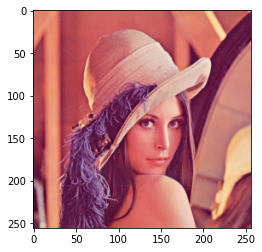

In [7]:
# Read lena image
img_path = '/content/drive/My Drive/Tensor-Completion/Code/data/lena_red.bmp'
img = cv2.imread(img_path, 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256)) / 255
plt.imshow(img)
print("img shape: ", img.shape)

img = cp.asarray(img)

In [0]:
def run_TR_experiment(img, ranks=[10], n_epochs=10000, gtol=1e-6):
  rses = {}
  predictions = {}

  for rank in ranks:
    start = time.time()
    tr_ranks = [rank] * 4
    # Mask the tensor
    img_masked = mask_img(img, missing_rate=0.7)

    # Train the model
    model = TR_WOPT_Model(img_masked, tr_ranks, optimization="ncg")
    model.train(n_epochs, gtol)

    # Compute the RSE of our prediction
    prediction = model.predict()
    prediction = prediction.clip(0, 1)
    rse = RSE(img, prediction)
    end = time.time()

    print("rank:", rank)
    print("rse:", rse)
    print("time:", end-start)

    rses[f"rank_{rank}"] = rse
    predictions[f"rank_{rank}"] = prediction

  return predictions, rses

In [10]:
# Run TR experiment for the same ranks as in the paper
ranks = [12, 24, 36, 48]
predictions, rses = run_TR_experiment(img, ranks, 10000, gtol=1e-7)

         Current function value: 0.000121
         Iterations: 10000
         Function evaluations: 19038
         Gradient evaluations: 19038
rank: 12
rse: 0.25542073586121466
time: 130.94840097427368
Optimization terminated successfully.
         Current function value: 0.000032
         Iterations: 6586
         Function evaluations: 12427
         Gradient evaluations: 12427
rank: 24
rse: 0.37153933420927865
time: 254.8659737110138
Optimization terminated successfully.
         Current function value: 0.000024
         Iterations: 3132
         Function evaluations: 5528
         Gradient evaluations: 5528
rank: 36
rse: 0.5598606775990402
time: 273.72856521606445
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 3136
         Function evaluations: 5448
         Gradient evaluations: 5448
rank: 48
rse: 0.6310598644000414
time: 505.1769177913666


In [11]:
rses

{'rank_12': 0.25542073586121466,
 'rank_24': 0.37153933420927865,
 'rank_36': 0.5598606775990402,
 'rank_48': 0.6310598644000414}

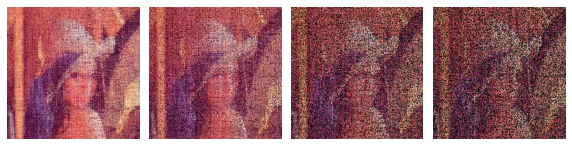

In [12]:
fig = plt.figure(figsize=(10, 10))
n_img = 4

for i, prediction in enumerate(predictions.values()):
  fig.add_subplot(3, 5, i+1)
  plt.axis("off")
  plt.imshow(cp.asnumpy(prediction))

fig.tight_layout(pad=1.0)